In [5]:
# Import the utility functions
from src.attention_analysis_utils import (
    generate_att_dict,
    generate_att_dict_sim,
    attattribute,
    attattribute_sim,
    avgatt
)
from torch_geometric.utils import get_num_hops
import torch

device = torch.device("cpu")
dataset_folder = "/workspace/Datasets"
model_folder = "/workspace/Models"

# Load the network data locally (for reproduction)
data = torch.load(f"{dataset_folder}/BA-Shapes.pt").to(device)
# Load model as a whole
model = torch.load(f"{model_folder}/GAT_BAShapes_2L1H.pt").to(device)
model.eval()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
# Now, we have everything that we need to run the experiment on a single target node.
# The experiment is run as follows.
# 1. We select a target node (given as a parameter to the function)
# 2. Get all edges within the target node's k-hop neighborhood
# 3. For all edges in the k-hop neighborhood, we get the attribution scores
# according to ATTATTRIBUTE, ATTATTRIBUTE_sim, and AVGATT.
# 4. Now, get the 1) label 2) prediction 3) prediction probability 4) entropy values of the original model
# 5. Now, we mask each edge acquired in step 2, and get the 1) label 2) prediction 3) prediction probability 4) entropy values
# by masking the edge.
# 6. Compare the importance ranking between the three scores in step 3 and the change in the values in step 5.
# Just do this for one target node for now.

# Import the utility functions
from attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    reindex_nodes_per_level,
    translate_comp_graph,
    get_att_dict_per_layer,
    get_ATTATTTRIBUTE_edge,
    get_AVGATT_edge,
    return_edges_in_k_hop,
)

from torch_geometric.utils import get_num_hops, get_num_hops

from typing import Tuple

import torch
from models import GAT_L2_intervention
from attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    reindex_nodes_per_level,
    translate_comp_graph,
    get_att_dict_per_layer,
    get_ATTATTTRIBUTE_edge,
    get_AVGATT_edge,
    return_edges_in_k_hop,
)
from torch_geometric.utils import get_num_hops
from typing import Tuple
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


def get_edge_scores(
    target_edge: Tuple, comp_graph, comp_graph_new, layer_att_dict, att
):
    assert type(target_edge) == tuple, "target_edge must be a tuple"
    # Get ATTATTRIBUTE & ATTATTRIBUTE_sim scores
    attattribute, attattribute_sim = get_ATTATTTRIBUTE_edge(
        comp_graph=comp_graph,
        comp_graph_new=comp_graph_new,
        layer_att_dict=layer_att_dict,
        target_edge=target_edge,
        verbose=False,
    )
    # Get AVGATT scores
    avgatt = get_AVGATT_edge(att=att, edge=target_edge)

    return attattribute, attattribute_sim, avgatt



# Let's refactor tha code below as a function
def experiment_on_target_node(
    target_idx: int, data, model, self_loops=True, verbose=False
):
    # 1. Get the number of hops according to the model
    num_hops = get_num_hops(model)
    # 2. Get all edges within the target node's k-hop neighborhood
    edge_lists = return_edges_in_k_hop(
        data=data, target_idx=target_idx, hop=2, self_loops=self_loops
    )
    if verbose:
        print(f"Number of edges in the k-hop neighborhood: {len(edge_lists)}")

    # 3. For all edges in the k-hop neighborhood, we get the attribution scores
    # according to ATTATTRIBUTE, ATTATTRIBUTE_sim, and AVGATT.
    # First, prepare ingredients for analysis

    num_layers = get_num_hops(model)
    att_dict_raw = get_attention_raw_dict(model, data)
    att_dict = process_attention_dict(att_dict_raw)
    comp_graph = get_computation_graph(
        edge_index=data.edge_index, k=num_layers, target_idx=target_idx
    )
    (
        nodes_per_level_original,
        num_nodes_per_level,
        true_node_label,
    ) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
    nodes_per_level_new = reindex_nodes_per_level(
        nodes_per_level_original, num_nodes_per_level
    )
    comp_graph_new = translate_comp_graph(
        comp_graph=comp_graph,
        nodes_per_level_new=nodes_per_level_new,
        nodes_per_level_original=nodes_per_level_original,
    )
    layer_att_dict = get_att_dict_per_layer(
        comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
    )

    # 4. Now, get the 1) label 2) prediction 3) prediction probability 4) entropy values of the original model
    # Output without any masking
    with torch.no_grad():
        output = model(
            x=data.x, edge_index=data.edge_index, return_att=True, mask_edge=None
        )
        att = model.att
        pred = output.argmax(dim=1)[target_idx].item()  # Single integer
        pred_prob = output[target_idx].softmax(dim=0)[pred].item()  # Single float
        prob_vector = output[target_idx].softmax(dim=0)  # 1D vector of floats
        entropy = -(prob_vector * prob_vector.log()).sum().item()  # Single float
    # Get results for all edges in the k-hop neighborhood
    attattribute_list, attattribute_sim_list, avgatt_list = [], [], []
    for current_edge in edge_lists:
        attattribute, attattribute_sim, avgatt = get_edge_scores(
            target_edge=tuple(current_edge),
            comp_graph=comp_graph,
            comp_graph_new=comp_graph_new,
            layer_att_dict=layer_att_dict,
            att=att,
        )
        attattribute_list.append(attattribute)
        attattribute_sim_list.append(attattribute_sim)
        avgatt_list.append(avgatt)
        if verbose:
            print(
                f"Current edge: ({current_edge[0]:4d}, {current_edge[1]:4d}), ATTATTRIBUTE: {attattribute:.4f}, ATTATTRIBUTE_sim: {attattribute_sim:.4f}, AVGATT: {avgatt:.4f}"
            )

    # 5. Now, we mask each edge acquired in step 2, and get the 1) label 2) prediction 3) prediction probability 4) entropy values
    # by masking the edge.
    # Output with masking
    pred_list_masked, pred_prob_list_masked, entropy_list_masked = [], [], []
    for current_edge in edge_lists:
        with torch.no_grad():
            output_masked = model(
                x=data.x,
                edge_index=data.edge_index,
                return_att=True,
                mask_edge=current_edge,
            )
            att_masked = model.att
            pred_masked = output_masked.argmax(dim=1)[target_idx].item()
            pred_prob_masked = (
                output_masked[target_idx].softmax(dim=0)[pred_masked].item()
            )
            prob_vector_masked = output_masked[target_idx].softmax(dim=0)
            entropy_masked = (
                -(prob_vector_masked * prob_vector_masked.log()).sum().item()
            )
        pred_list_masked.append(pred_masked)
        pred_prob_list_masked.append(pred_prob_masked)
        entropy_list_masked.append(entropy_masked)
        if verbose:
            print(
                f"Current edge: ({current_edge[0]:4d}, {current_edge[1]:4d}), prediction: {pred:1d} → {pred_masked:1d}, Δpred_prob: {pred_prob - pred_prob_masked:.4f}, Δentropy: {entropy - entropy_masked:.4f}"
            )
    # For pred_list_masked, change into a list of bools indicating whether the prediction has changed
    # Compare pred_list_masked with
    pred_list_masked_bool = [pred != curr_pred for curr_pred in pred_list_masked]
    # For pred_prob_list_masked, change into a list of floats indicating the change in prediction probability
    pred_prob_list_masked_float = [
        pred_prob - curr_pred_prob for curr_pred_prob in pred_prob_list_masked
    ]
    # For entropy_list_masked, change into a list of floats indicating the change in entropy
    entropy_list_masked_float = [
        curr_entropy - entropy for curr_entropy in entropy_list_masked
    ]

    return (
        attattribute_list,
        attattribute_sim_list,
        avgatt_list,
        pred_list_masked_bool,
        pred_prob_list_masked_float,
        entropy_list_masked_float,
    )

#### Code for runnint experiments (do not run these cell unless re-experimenting)

#### BA-Shapes

Main experiment

GAT_BAShapes_2L1H.pt

In [ ]:
import torch

dataset_name = "BA-Shapes"
model_name = "GAT_BAShapes_2L1H"

device = torch.device("cpu")
# Load the network data locally (for reproduction)
data = torch.load(f"/workspace/{dataset_name}.pt").to(device)
# Load the trained model locally (for reproduction)
model = torch.load(f"/workspace/{model_name}.pt").to(device)
model.eval()

with torch.no_grad():
    att = model.att

In [ ]:
# Run and stack the results of the experiment for all nodes in data.unique_solution_nodes

attattribute_list, attattribute_sim_list, avgatt_list = [], [], []
pred_list_masked_bool, pred_prob_list_masked_float, entropy_list_masked_float = (
    [],
    [],
    [],
)
for target_node in range(300, 700):
    target_node_results = experiment_on_target_node(
        target_idx=target_node,
        data=data,
        model=model,
        self_loops=True,
        verbose=False,
    )
    attattribute_list_curr = target_node_results[0]
    attattribute_sim_list_curr = target_node_results[1]
    avgatt_list_curr = target_node_results[2]
    pred_list_masked_bool_curr = target_node_results[3]
    pred_prob_list_masked_float_curr = target_node_results[4]
    entropy_list_masked_float_curr = target_node_results[5]

    attattribute_list.extend(attattribute_list_curr)
    attattribute_sim_list.extend(attattribute_sim_list_curr)
    avgatt_list.extend(avgatt_list_curr)
    pred_list_masked_bool.extend(pred_list_masked_bool_curr)
    pred_prob_list_masked_float.extend(pred_prob_list_masked_float_curr)
    entropy_list_masked_float.extend(entropy_list_masked_float_curr)

torch.save(
    torch.Tensor(attattribute_list),
    f"/workspace/{dataset_name}_{model_name}_attattribute_list.pt",
)
torch.save(
    torch.Tensor(attattribute_sim_list),
    f"/workspace/{dataset_name}_{model_name}_attattribute_sim_list.pt",
)
torch.save(
    torch.Tensor(avgatt_list), f"/workspace/{dataset_name}_{model_name}_avgatt_list.pt"
)
torch.save(
    torch.Tensor(pred_list_masked_bool),
    f"/workspace/{dataset_name}_{model_name}_pred_list_masked_bool.pt",
)
torch.save(
    torch.Tensor(pred_prob_list_masked_float),
    f"/workspace/{dataset_name}_{model_name}_pred_prob_list_masked_float.pt",
)
torch.save(
    torch.Tensor(entropy_list_masked_float),
    f"/workspace/{dataset_name}_{model_name}_entropy_list_masked_float.pt",
)

In [ ]:
# Load experiments from local

attattribute_list = torch.load(
    f"/workspace/{dataset_name}_{model_name}_attattribute_list.pt"
)
attattribute_sim_list = torch.load(
    f"/workspace/{dataset_name}_{model_name}_attattribute_sim_list.pt"
)
avgatt_list = torch.load(f"/workspace/{dataset_name}_{model_name}_avgatt_list.pt")
pred_list_masked_bool = torch.load(
    f"/workspace/{dataset_name}_{model_name}_pred_list_masked_bool.pt"
)
pred_prob_list_masked_float = torch.load(
    f"/workspace/{dataset_name}_{model_name}_pred_prob_list_masked_float.pt"
)
entropy_list_masked_float = torch.load(
    f"/workspace/{dataset_name}_{model_name}_entropy_list_masked_float.pt"
)

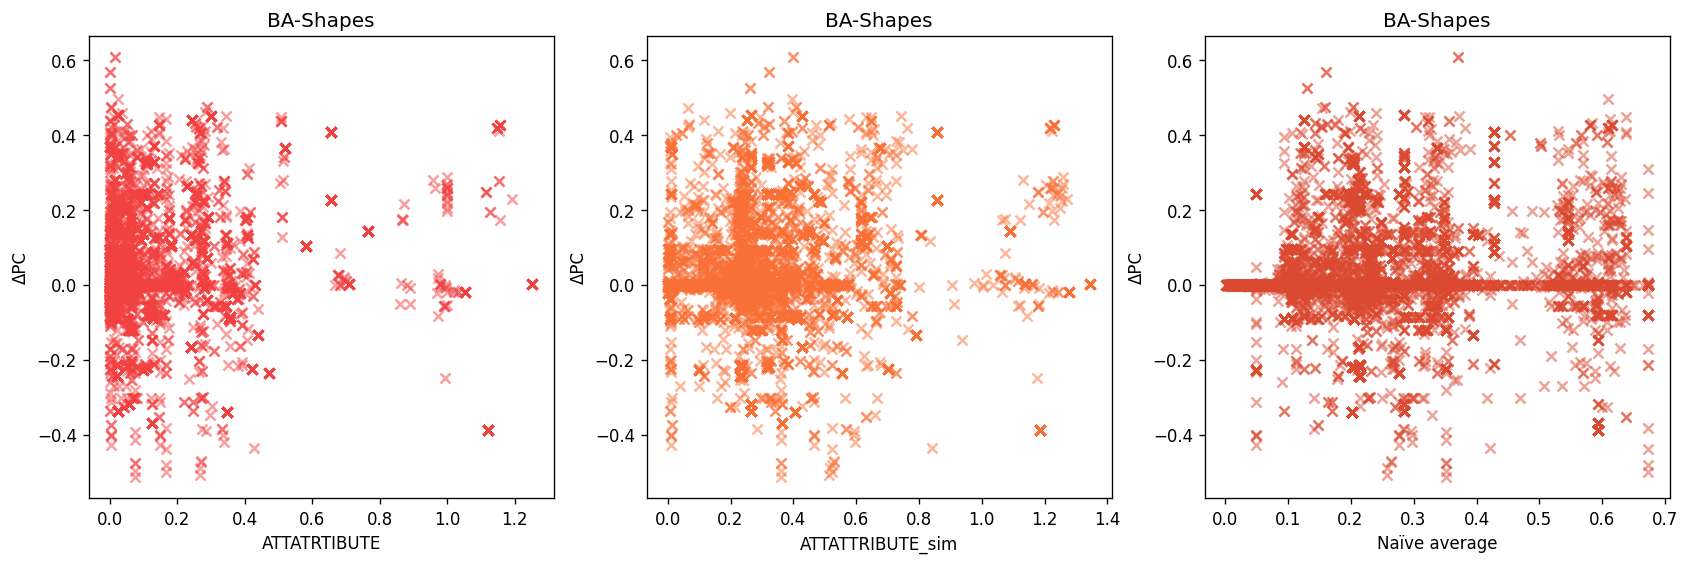

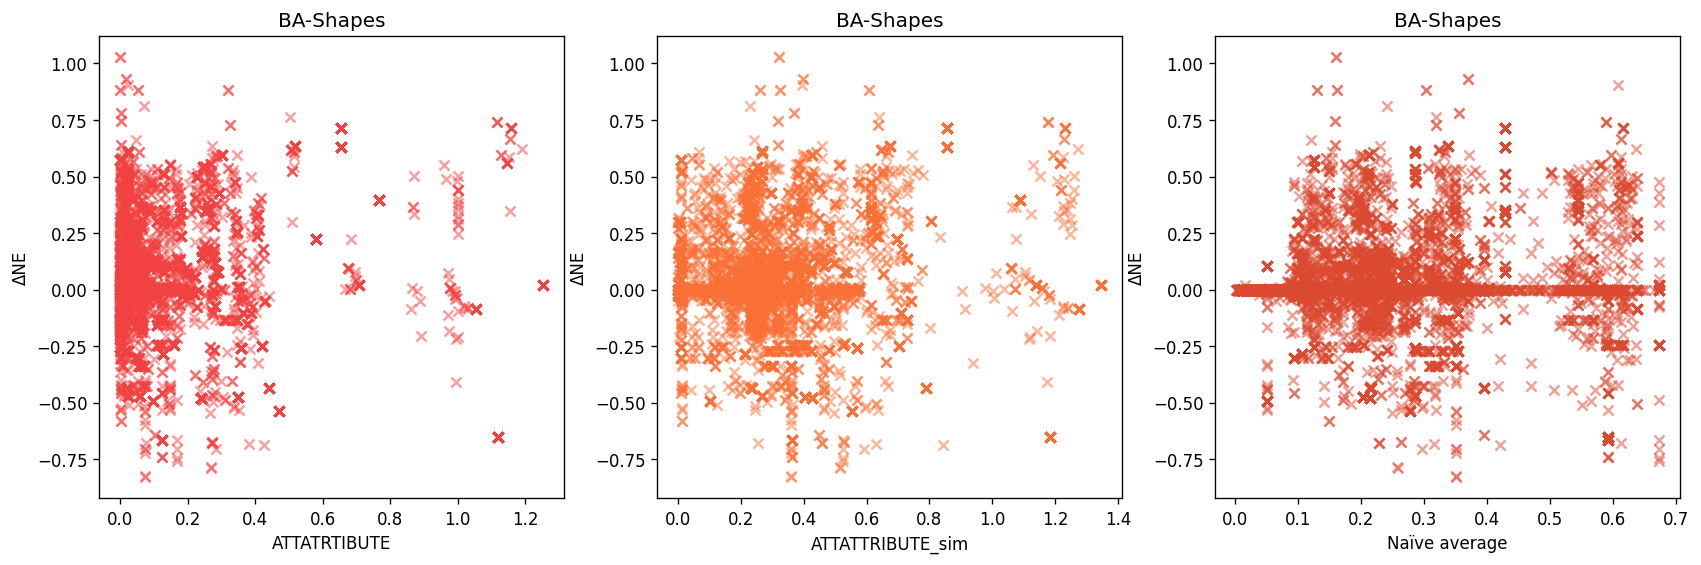

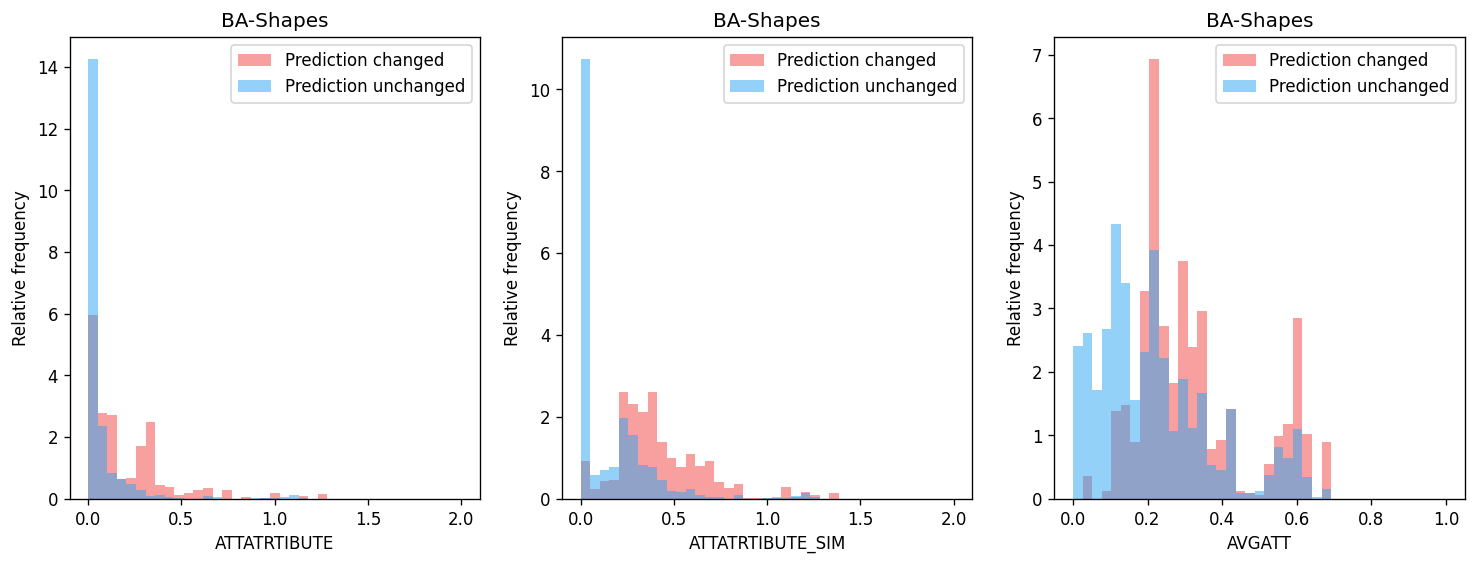

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Flag to whether print statistics in the figure
PRINT_CORRELATION_COEFFICIENT = False

fig, axs = plt.subplots(1, 3, figsize=(17, 5), dpi=120)
# Scatter plot with alpha=0.5, color #f24141
axs[0].scatter(
    attattribute_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#f24141",
    marker="x",
    label="ATTATRTIBUTE",
)
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr, _ = pearsonr(attattribute_list, pred_prob_list_masked_float)
    axs[0].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr,
        transform=axs[0].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

# Scatter plot with alpha=0.5, color #F97037
axs[1].scatter(
    attattribute_sim_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#F97037",
    marker="x",
    label="ATTATTRIBUTE_sim",
)
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATTRIBUTE_sim")
axs[1].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr_sim, _ = pearsonr(attattribute_sim_list, pred_prob_list_masked_float)
    axs[1].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr_sim,
        transform=axs[1].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

# Scatter plot with alpha=0.5, color #DB4930
axs[2].scatter(
    avgatt_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#DB4930",
    marker="x",
    label="Naive average",
)
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("Naïve average")
axs[2].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_avgatt, _ = pearsonr(avgatt_list, pred_prob_list_masked_float)
    axs[2].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_avgatt,
        transform=axs[2].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

plt.show()

# Plot a similar graph but use entropy instead of prediction difference
# Set the figure size to (17, 5)
# Also show the correlation coefficient for each cases inside the corresponding subplot

fig, axs = plt.subplots(1, 3, figsize=(17, 5), dpi=120)
axs[0].scatter(
    attattribute_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#f24141",
    marker="x",
    label="ATTATRTIBUTE",
)
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr, _ = pearsonr(attattribute_list, entropy_list_masked_float)
    axs[0].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr,
        transform=axs[0].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

axs[1].scatter(
    attattribute_sim_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#F97037",
    marker="x",
    label="ATTATTRIBUTE_sim",
)
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATTRIBUTE_sim")
axs[1].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr_sim, _ = pearsonr(attattribute_sim_list, entropy_list_masked_float)
    axs[1].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr_sim,
        transform=axs[1].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

axs[2].scatter(
    avgatt_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#DB4930",
    marker="x",
    label="Naive average",
)
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("Naïve average")
axs[2].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_avgatt, _ = pearsonr(avgatt_list, entropy_list_masked_float)
    axs[2].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_avgatt,
        transform=axs[2].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

plt.show()

# Also, plot the data in pred_list_masked_bool (list of 0 and 1s) as a histogram
# For example, we can divide attattribute_list into two groups:
# 1. pred_list_masked_bool = 1
# 2. pred_list_masked_bool = 0
# Then, we can plot the histogram of the two groups in the same plot
# Adjust the alpha value to make the two histograms distinguishable
# The x-axis is the attribute value, and the y-axis is the frequency
# The title of the plot is still the dataset name
# Like above, we can also plot the histogram of the two groups in the same plot
# Do it for all three attattribute_list, attattribute_sim_list, and avgatt_list

# First get the max value of the three lists
max_attattribute_list = max(attattribute_list).ceil()
max_attattribute_sim_list = max(attattribute_sim_list).ceil()
max_avgatt_list = max(avgatt_list).ceil()

# Make two masking tensors from pred_list_masked_bool that are complementary
mask_remained = torch.logical_not(pred_list_masked_bool)
mask_flipped = pred_list_masked_bool.bool()

# Make the bins used for the histogram
bins_attattribute = torch.linspace(0, max_attattribute_list, 40)
bins_attattribute_sim = torch.linspace(0, max_attattribute_sim_list, 40)
bins_avgatt = torch.linspace(0, max_avgatt_list, 40)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120)
axs[0].hist(attattribute_list[mask_flipped], 
            bins=bins_attattribute, 
            density=True,
            alpha=0.5, 
            color="#F24141",
            label='Prediction changed')
axs[0].hist(attattribute_list[mask_remained], 
            bins=bins_attattribute, 
            density=True,
            alpha=0.5, 
            color="#29A5F2",
            label='Prediction unchanged')
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("Relative frequency")

axs[1].hist(attattribute_sim_list[mask_flipped], 
            bins=bins_attattribute_sim, 
            alpha=0.5, 
            density=True,
            color="#F24141",
            label='Prediction changed')
axs[1].hist(attattribute_sim_list[mask_remained], 
            bins=bins_attattribute_sim, 
            alpha=0.5, 
            density=True,
            color="#29A5F2",
            label='Prediction unchanged')
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATRTIBUTE_SIM")
axs[1].set_ylabel("Relative frequency")

axs[2].hist(avgatt_list[mask_flipped], 
            bins=bins_avgatt, 
            alpha=0.5, 
            density=True,
            color="#F24141",
            label='Prediction changed')
axs[2].hist(avgatt_list[mask_remained], 
            bins=bins_avgatt, 
            alpha=0.5, 
            density=True,
            color="#29A5F2",
            label='Prediction unchanged')
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("AVGATT")
axs[2].set_ylabel("Relative frequency")

# Add the legend
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.show()

In [ ]:
# Statistical testing with Kendall's Tau and Spearman's Rho, Pearson's Rho
# Also include the ROC AUC score between each attribution and the decision change in pred_list_masked_bool
# Kendall's Tau is a non-parametric test for the strength of association between two variables
# Spearman's Rho is a non-parametric test for the strength of monotonic association between two variables
from scipy.stats import kendalltau, spearmanr, pearsonr
from sklearn.metrics import roc_auc_score

"""
    Compare...
    1. pred_prob_list_masked_float vs. attattribute_list
    2. pred_prob_list_masked_float vs. attattribute_sim_list
    3. pred_prob_list_masked_float vs. avgatt_list
    4. entropy_list_masked_float vs. attattribute_list
    5. entropy_list_masked_float vs. attattribute_sim_list
    6. entropy_list_masked_float vs. avgatt_list
    7. ROC AUC score between each attribution and the decision change in pred_list_masked_bool
"""
# Also include a random baseline
random_attr = torch.rand(pred_prob_list_masked_float.shape)

random_attr_kendall = kendalltau(pred_prob_list_masked_float, random_attr)
random_attr_spearman = spearmanr(pred_prob_list_masked_float, random_attr)
random_attr_pearson = pearsonr(pred_prob_list_masked_float, random_attr)
random_attr_entropy_kendall = kendalltau(entropy_list_masked_float, random_attr)
random_attr_entropy_spearman = spearmanr(entropy_list_masked_float, random_attr)
random_attr_entropy_pearson = pearsonr(entropy_list_masked_float, random_attr)
random_attr_roc_auc = roc_auc_score(pred_list_masked_bool, random_attr)

# Print results
print("RANDOM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{random_attr_kendall[0]:.4f}, {random_attr_spearman[0]:.4f}, {random_attr_pearson[0]:.4f}")
print("RANDOM vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{random_attr_entropy_kendall[0]:.4f}, {random_attr_entropy_spearman[0]:.4f}, {random_attr_entropy_pearson[0]:.4f}")
print("RANDOM vs. Δprob: ROC AUC")
print(f"{random_attr_roc_auc:.4f}")


attattribute_prob_kendall = kendalltau(pred_prob_list_masked_float, attattribute_list)
attattribute_prob_spearman = spearmanr(pred_prob_list_masked_float, attattribute_list)
attattribute_prob_pearson = pearsonr(pred_prob_list_masked_float, attattribute_list)

attattribute_sim_prob_kendall = kendalltau(
    pred_prob_list_masked_float, attattribute_sim_list
)
attattribute_sim_prob_spearman = spearmanr(
    pred_prob_list_masked_float, attattribute_sim_list
)
attattribute_sim_prob_pearson = pearsonr(
    pred_prob_list_masked_float, attattribute_sim_list
)

avgatt_prob_kendall = kendalltau(pred_prob_list_masked_float, avgatt_list)
avgatt_prob_spearman = spearmanr(pred_prob_list_masked_float, avgatt_list)
avgatt_prob_pearson = pearsonr(pred_prob_list_masked_float, avgatt_list)

attattribute_entropy_kendall = kendalltau(entropy_list_masked_float, attattribute_list)
attattribute_entropy_spearman = spearmanr(entropy_list_masked_float, attattribute_list)
attattribute_entropy_pearson = pearsonr(entropy_list_masked_float, attattribute_list)

attattribute_sim_entropy_kendall = kendalltau(
    entropy_list_masked_float, attattribute_sim_list
)
attattribute_sim_entropy_spearman = spearmanr(
    entropy_list_masked_float, attattribute_sim_list
)
attattribute_sim_entropy_pearson = pearsonr(
    entropy_list_masked_float, attattribute_sim_list
)

avgatt_entropy_kendall = kendalltau(entropy_list_masked_float, avgatt_list)
avgatt_entropy_spearman = spearmanr(entropy_list_masked_float, avgatt_list)
avgatt_entropy_pearson = pearsonr(entropy_list_masked_float, avgatt_list)


attattribute_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_list)
attattribute_sim_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_sim_list)
avgatt_roc_auc = roc_auc_score(pred_list_masked_bool, avgatt_list)

# Print results
print("ATTATTRIBUTE vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_prob_kendall[0]:.4f}, {attattribute_prob_spearman[0]:.4f}, {attattribute_prob_pearson[0]:.4f}")
print("ATTATTRIBUTE_SIM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_sim_prob_kendall[0]:.4f}, {attattribute_sim_prob_spearman[0]:.4f}, {attattribute_sim_prob_pearson[0]:.4f}")
print("AVGATT vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{avgatt_prob_kendall[0]:.4f}, {avgatt_prob_spearman[0]:.4f}, {avgatt_prob_pearson[0]:.4f}")
print("ATTATTRIBUTE vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_entropy_kendall[0]:.4f}, {attattribute_entropy_spearman[0]:.4f}, {attattribute_entropy_pearson[0]:.4f}")
print("ATTATTRIBUTE_SIM vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_sim_entropy_kendall[0]:.4f}, {attattribute_sim_entropy_spearman[0]:.4f}, {attattribute_sim_entropy_pearson[0]:.4f}")
print("AVGATT vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{avgatt_entropy_kendall[0]:.4f}, {avgatt_entropy_spearman[0]:.4f}, {avgatt_entropy_pearson[0]:.4f}")
print("ROC AUC for ATTATTRIBUTE / ATTATTRIBUTE_SIM / AVGATT")
print(f"{attattribute_roc_auc:.4f}, {attattribute_sim_roc_auc:.4f}, {avgatt_roc_auc:.4f}")

RANDOM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
-0.0080, -0.0114, -0.0117
RANDOM vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
-0.0053, -0.0077, -0.0104
RANDOM vs. Δprob: ROC AUC
0.4970
ATTATTRIBUTE vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.0756, 0.1035, 0.0825
ATTATTRIBUTE_SIM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.0693, 0.0963, 0.1138
AVGATT vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.0391, 0.0603, 0.0416
ATTATTRIBUTE vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.0810, 0.1132, 0.1055
ATTATTRIBUTE_SIM vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.0752, 0.1074, 0.1154
AVGATT vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.0468, 0.0682, 0.0543
ROC AUC for ATTATTRIBUTE / ATTATTRIBUTE_SIM / AVGATT
0.8224, 0.8469, 0.7092


GAT_BAShapes_3L1H

In [ ]:
import torch

dataset_name = "BA-Shapes"
model_name = "GAT_BAShapes_3L1H"

device = torch.device("cpu")
# Load the network data locally (for reproduction)
data = torch.load(f"/workspace/{dataset_name}.pt").to(device)
# Load the trained model locally (for reproduction)
model = torch.load(f"/workspace/{model_name}.pt").to(device)
model.eval()

with torch.no_grad():
    att = model.att

In [ ]:
# Run and stack the results of the experiment for all nodes in data.unique_solution_nodes

attattribute_list, attattribute_sim_list, avgatt_list = [], [], []
pred_list_masked_bool, pred_prob_list_masked_float, entropy_list_masked_float = (
    [],
    [],
    [],
)
for target_node in range(300, 700):
    target_node_results = experiment_on_target_node(
        target_idx=target_node,
        data=data,
        model=model,
        self_loops=True,
        verbose=False,
    )
    attattribute_list_curr = target_node_results[0]
    attattribute_sim_list_curr = target_node_results[1]
    avgatt_list_curr = target_node_results[2]
    pred_list_masked_bool_curr = target_node_results[3]
    pred_prob_list_masked_float_curr = target_node_results[4]
    entropy_list_masked_float_curr = target_node_results[5]

    attattribute_list.extend(attattribute_list_curr)
    attattribute_sim_list.extend(attattribute_sim_list_curr)
    avgatt_list.extend(avgatt_list_curr)
    pred_list_masked_bool.extend(pred_list_masked_bool_curr)
    pred_prob_list_masked_float.extend(pred_prob_list_masked_float_curr)
    entropy_list_masked_float.extend(entropy_list_masked_float_curr)

torch.save(
    torch.Tensor(attattribute_list),
    f"/workspace/{dataset_name}_{model_name}_attattribute_list.pt",
)
torch.save(
    torch.Tensor(attattribute_sim_list),
    f"/workspace/{dataset_name}_{model_name}_attattribute_sim_list.pt",
)
torch.save(
    torch.Tensor(avgatt_list), f"/workspace/{dataset_name}_{model_name}_avgatt_list.pt"
)
torch.save(
    torch.Tensor(pred_list_masked_bool),
    f"/workspace/{dataset_name}_{model_name}_pred_list_masked_bool.pt",
)
torch.save(
    torch.Tensor(pred_prob_list_masked_float),
    f"/workspace/{dataset_name}_{model_name}_pred_prob_list_masked_float.pt",
)
torch.save(
    torch.Tensor(entropy_list_masked_float),
    f"/workspace/{dataset_name}_{model_name}_entropy_list_masked_float.pt",
)

In [ ]:
# Load experiments from local

attattribute_list = torch.load(
    f"/workspace/{dataset_name}_{model_name}_attattribute_list.pt"
)
attattribute_sim_list = torch.load(
    f"/workspace/{dataset_name}_{model_name}_attattribute_sim_list.pt"
)
avgatt_list = torch.load(f"/workspace/{dataset_name}_{model_name}_avgatt_list.pt")
pred_list_masked_bool = torch.load(
    f"/workspace/{dataset_name}_{model_name}_pred_list_masked_bool.pt"
)
pred_prob_list_masked_float = torch.load(
    f"/workspace/{dataset_name}_{model_name}_pred_prob_list_masked_float.pt"
)
entropy_list_masked_float = torch.load(
    f"/workspace/{dataset_name}_{model_name}_entropy_list_masked_float.pt"
)

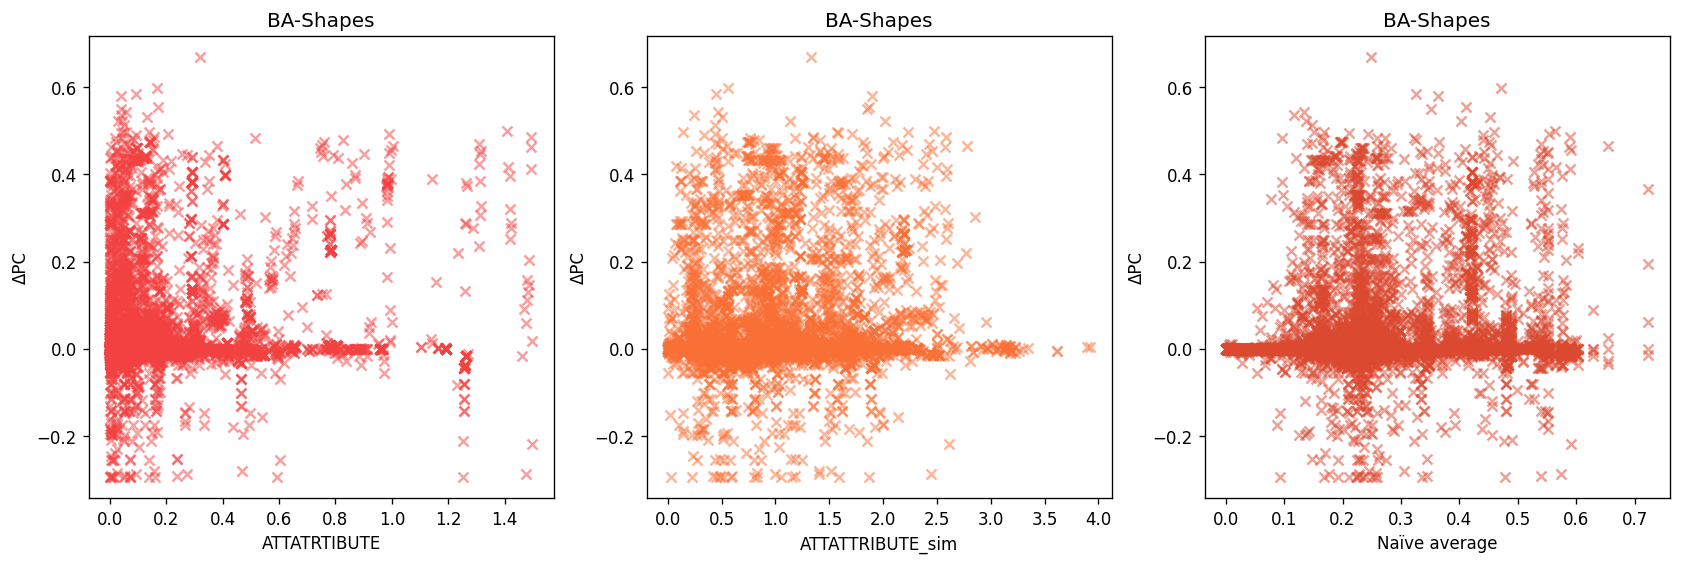

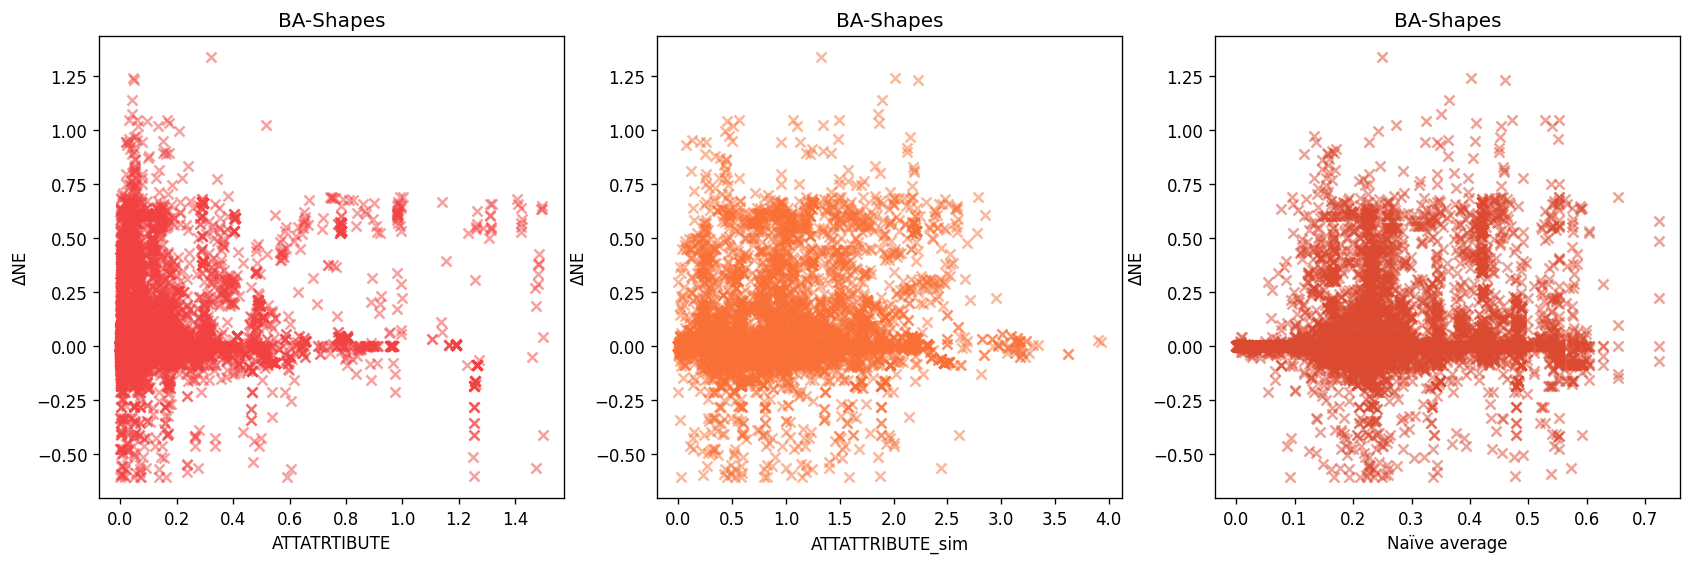

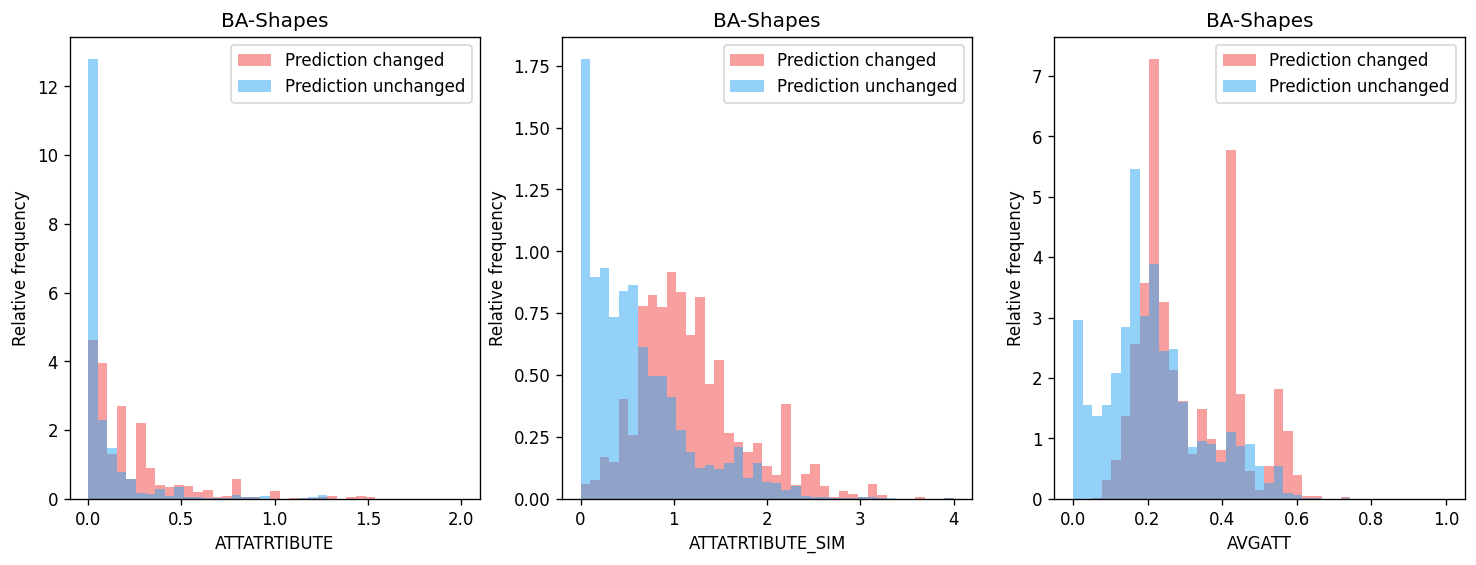

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Flag to whether print statistics in the figure
PRINT_CORRELATION_COEFFICIENT = False

fig, axs = plt.subplots(1, 3, figsize=(17, 5), dpi=120)
# Scatter plot with alpha=0.5, color #f24141
axs[0].scatter(
    attattribute_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#f24141",
    marker="x",
    label="ATTATRTIBUTE",
)
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr, _ = pearsonr(attattribute_list, pred_prob_list_masked_float)
    axs[0].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr,
        transform=axs[0].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

# Scatter plot with alpha=0.5, color #F97037
axs[1].scatter(
    attattribute_sim_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#F97037",
    marker="x",
    label="ATTATTRIBUTE_sim",
)
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATTRIBUTE_sim")
axs[1].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr_sim, _ = pearsonr(attattribute_sim_list, pred_prob_list_masked_float)
    axs[1].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr_sim,
        transform=axs[1].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

# Scatter plot with alpha=0.5, color #DB4930
axs[2].scatter(
    avgatt_list,
    pred_prob_list_masked_float,
    alpha=0.5,
    color="#DB4930",
    marker="x",
    label="Naive average",
)
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("Naïve average")
axs[2].set_ylabel("ΔPC")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_avgatt, _ = pearsonr(avgatt_list, pred_prob_list_masked_float)
    axs[2].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_avgatt,
        transform=axs[2].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

plt.show()

# Plot a similar graph but use entropy instead of prediction difference
# Set the figure size to (17, 5)
# Also show the correlation coefficient for each cases inside the corresponding subplot

fig, axs = plt.subplots(1, 3, figsize=(17, 5), dpi=120)
axs[0].scatter(
    attattribute_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#f24141",
    marker="x",
    label="ATTATRTIBUTE",
)
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr, _ = pearsonr(attattribute_list, entropy_list_masked_float)
    axs[0].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr,
        transform=axs[0].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

axs[1].scatter(
    attattribute_sim_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#F97037",
    marker="x",
    label="ATTATTRIBUTE_sim",
)
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATTRIBUTE_sim")
axs[1].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_attattr_sim, _ = pearsonr(attattribute_sim_list, entropy_list_masked_float)
    axs[1].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_attattr_sim,
        transform=axs[1].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

axs[2].scatter(
    avgatt_list,
    entropy_list_masked_float,
    alpha=0.5,
    color="#DB4930",
    marker="x",
    label="Naive average",
)
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("Naïve average")
axs[2].set_ylabel("ΔNE")
if PRINT_CORRELATION_COEFFICIENT:
    coeff_avgatt, _ = pearsonr(avgatt_list, entropy_list_masked_float)
    axs[2].text(
        0.05,
        0.95,
        "Correlation Coefficient: %.3f" % coeff_avgatt,
        transform=axs[2].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

plt.show()

# Also, plot the data in pred_list_masked_bool (list of 0 and 1s) as a histogram
# For example, we can divide attattribute_list into two groups:
# 1. pred_list_masked_bool = 1
# 2. pred_list_masked_bool = 0
# Then, we can plot the histogram of the two groups in the same plot
# Adjust the alpha value to make the two histograms distinguishable
# The x-axis is the attribute value, and the y-axis is the frequency
# The title of the plot is still the dataset name
# Like above, we can also plot the histogram of the two groups in the same plot
# Do it for all three attattribute_list, attattribute_sim_list, and avgatt_list

# First get the max value of the three lists
max_attattribute_list = max(attattribute_list).ceil()
max_attattribute_sim_list = max(attattribute_sim_list).ceil()
max_avgatt_list = max(avgatt_list).ceil()

# Make two masking tensors from pred_list_masked_bool that are complementary
mask_remained = torch.logical_not(pred_list_masked_bool)
mask_flipped = pred_list_masked_bool.bool()

# Make the bins used for the histogram
bins_attattribute = torch.linspace(0, max_attattribute_list, 40)
bins_attattribute_sim = torch.linspace(0, max_attattribute_sim_list, 40)
bins_avgatt = torch.linspace(0, max_avgatt_list, 40)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=120)
axs[0].hist(attattribute_list[mask_flipped], 
            bins=bins_attattribute, 
            density=True,
            alpha=0.5, 
            color="#F24141",
            label='Prediction changed')
axs[0].hist(attattribute_list[mask_remained], 
            bins=bins_attattribute, 
            density=True,
            alpha=0.5, 
            color="#29A5F2",
            label='Prediction unchanged')
axs[0].set_title(f"{dataset_name}")
axs[0].set_xlabel("ATTATRTIBUTE")
axs[0].set_ylabel("Relative frequency")

axs[1].hist(attattribute_sim_list[mask_flipped], 
            bins=bins_attattribute_sim, 
            alpha=0.5, 
            density=True,
            color="#F24141",
            label='Prediction changed')
axs[1].hist(attattribute_sim_list[mask_remained], 
            bins=bins_attattribute_sim, 
            alpha=0.5, 
            density=True,
            color="#29A5F2",
            label='Prediction unchanged')
axs[1].set_title(f"{dataset_name}")
axs[1].set_xlabel("ATTATRTIBUTE_SIM")
axs[1].set_ylabel("Relative frequency")

axs[2].hist(avgatt_list[mask_flipped], 
            bins=bins_avgatt, 
            alpha=0.5, 
            density=True,
            color="#F24141",
            label='Prediction changed')
axs[2].hist(avgatt_list[mask_remained], 
            bins=bins_avgatt, 
            alpha=0.5, 
            density=True,
            color="#29A5F2",
            label='Prediction unchanged')
axs[2].set_title(f"{dataset_name}")
axs[2].set_xlabel("AVGATT")
axs[2].set_ylabel("Relative frequency")

# Add the legend
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.show()

In [ ]:
# Statistical testing with Kendall's Tau and Spearman's Rho, Pearson's Rho
# Also include the ROC AUC score between each attribution and the decision change in pred_list_masked_bool
# Kendall's Tau is a non-parametric test for the strength of association between two variables
# Spearman's Rho is a non-parametric test for the strength of monotonic association between two variables
from scipy.stats import kendalltau, spearmanr, pearsonr
from sklearn.metrics import roc_auc_score

"""
    Compare...
    1. pred_prob_list_masked_float vs. attattribute_list
    2. pred_prob_list_masked_float vs. attattribute_sim_list
    3. pred_prob_list_masked_float vs. avgatt_list
    4. entropy_list_masked_float vs. attattribute_list
    5. entropy_list_masked_float vs. attattribute_sim_list
    6. entropy_list_masked_float vs. avgatt_list
    7. ROC AUC score between each attribution and the decision change in pred_list_masked_bool
"""
# Also include a random baseline
random_attr = torch.rand(pred_prob_list_masked_float.shape)

random_attr_kendall = kendalltau(pred_prob_list_masked_float, random_attr)
random_attr_spearman = spearmanr(pred_prob_list_masked_float, random_attr)
random_attr_pearson = pearsonr(pred_prob_list_masked_float, random_attr)
# random_attr_entropy_kendall = kendalltau(entropy_list_masked_float, random_attr)
# random_attr_entropy_spearman = spearmanr(entropy_list_masked_float, random_attr)
# random_attr_entropy_pearson = pearsonr(entropy_list_masked_float, random_attr)
random_attr_roc_auc = roc_auc_score(pred_list_masked_bool, random_attr)

# Print results
print("RANDOM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{random_attr_kendall[0]:.4f}, {random_attr_spearman[0]:.4f}, {random_attr_pearson[0]:.4f}")
# print("RANDOM vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
# print(f"{random_attr_entropy_kendall[0]:.4f}, {random_attr_entropy_spearman[0]:.4f}, {random_attr_entropy_pearson[0]:.4f}")
print("RANDOM vs. Δprob: ROC AUC")
print(f"{random_attr_roc_auc:.4f}")


attattribute_prob_kendall = kendalltau(pred_prob_list_masked_float, attattribute_list)
attattribute_prob_spearman = spearmanr(pred_prob_list_masked_float, attattribute_list)
attattribute_prob_pearson = pearsonr(pred_prob_list_masked_float, attattribute_list)

attattribute_sim_prob_kendall = kendalltau(
    pred_prob_list_masked_float, attattribute_sim_list
)
attattribute_sim_prob_spearman = spearmanr(
    pred_prob_list_masked_float, attattribute_sim_list
)
attattribute_sim_prob_pearson = pearsonr(
    pred_prob_list_masked_float, attattribute_sim_list
)

avgatt_prob_kendall = kendalltau(pred_prob_list_masked_float, avgatt_list)
avgatt_prob_spearman = spearmanr(pred_prob_list_masked_float, avgatt_list)
avgatt_prob_pearson = pearsonr(pred_prob_list_masked_float, avgatt_list)

# attattribute_entropy_kendall = kendalltau(entropy_list_masked_float, attattribute_list)
# attattribute_entropy_spearman = spearmanr(entropy_list_masked_float, attattribute_list)
# attattribute_entropy_pearson = pearsonr(entropy_list_masked_float, attattribute_list)

# attattribute_sim_entropy_kendall = kendalltau(
#     entropy_list_masked_float, attattribute_sim_list
# )
# attattribute_sim_entropy_spearman = spearmanr(
#     entropy_list_masked_float, attattribute_sim_list
# )
# attattribute_sim_entropy_pearson = pearsonr(
#     entropy_list_masked_float, attattribute_sim_list
# )

# avgatt_entropy_kendall = kendalltau(entropy_list_masked_float, avgatt_list)
# avgatt_entropy_spearman = spearmanr(entropy_list_masked_float, avgatt_list)
# avgatt_entropy_pearson = pearsonr(entropy_list_masked_float, avgatt_list)


attattribute_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_list)
attattribute_sim_roc_auc = roc_auc_score(pred_list_masked_bool, attattribute_sim_list)
avgatt_roc_auc = roc_auc_score(pred_list_masked_bool, avgatt_list)

# Print results
print("ATTATTRIBUTE vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_prob_kendall[0]:.4f}, {attattribute_prob_spearman[0]:.4f}, {attattribute_prob_pearson[0]:.4f}")
print("ATTATTRIBUTE_SIM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{attattribute_sim_prob_kendall[0]:.4f}, {attattribute_sim_prob_spearman[0]:.4f}, {attattribute_sim_prob_pearson[0]:.4f}")
print("AVGATT vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho")
print(f"{avgatt_prob_kendall[0]:.4f}, {avgatt_prob_spearman[0]:.4f}, {avgatt_prob_pearson[0]:.4f}")
# print("ATTATTRIBUTE vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
# print(f"{attattribute_entropy_kendall[0]:.4f}, {attattribute_entropy_spearman[0]:.4f}, {attattribute_entropy_pearson[0]:.4f}")
# print("ATTATTRIBUTE_SIM vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
# print(f"{attattribute_sim_entropy_kendall[0]:.4f}, {attattribute_sim_entropy_spearman[0]:.4f}, {attattribute_sim_entropy_pearson[0]:.4f}")
# print("AVGATT vs. Δentropy: Kendall's Tau / Spearman's Rho / Pearson's Rho")
# print(f"{avgatt_entropy_kendall[0]:.4f}, {avgatt_entropy_spearman[0]:.4f}, {avgatt_entropy_pearson[0]:.4f}")
print("ROC AUC for ATTATTRIBUTE / ATTATTRIBUTE_SIM / AVGATT")
print(f"{attattribute_roc_auc:.4f}, {attattribute_sim_roc_auc:.4f}, {avgatt_roc_auc:.4f}")

RANDOM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
-0.0028, -0.0042, -0.0013
RANDOM vs. Δprob: ROC AUC
0.4956
ATTATTRIBUTE vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.0657, 0.1037, 0.1700
ATTATTRIBUTE_SIM vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.0695, 0.1130, 0.1943
AVGATT vs. Δprob: Kendall's Tau / Spearman's Rho / Pearson's Rho
0.0602, 0.0993, 0.1520
ROC AUC for ATTATTRIBUTE / ATTATTRIBUTE_SIM / AVGATT
0.7700, 0.7972, 0.7024
